# 声質変換
- 音色の変換: 1フレームごとに対応付けて、GMMを学習: 特徴量はmcep dim 25 + ⊿, ⊿⊿
- 音高の変化: フレームごとのF0を線形変換。モデルのパラメータは別途用意。
## 1. ライブラリのインポート

In [5]:
from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.jvs import WavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames, delta_features
from nnmnkwii.util import apply_each2d_trim
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG

from os.path import basename, splitext
import sys
import time

import numpy as np
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display

# 2. 今回のデータの設定

In [6]:
fs = 24000 #サンプル周波数
fftlen = pyworld.get_cheaptrick_fft_size(fs) #フィルタの次元数(スペクトル包絡の係数)
alpha = pysptk.util.mcepalpha(fs) #メルケプストラムの変換係数
order = 24 #ケプストラムの次元数.ただし、0次元を除くため、変換後はorder+1次元となる。
frame_period = 5 #時間窓
hop_length = int(fs * (frame_period * 0.001))
max_files = 100 # データの総数
test_size = 0.03 #テストデータの比率
use_delta = True #動的特徴量の利用するかどうか。今回は⊿⊿まで利用。

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

# 3. データローダーの定義とデータロード
- nnmnkwiiでは、著名なデータ・セットの呼び出し部は定義している。
- だが、collect_files, collect_featuresは自分で定義しないといけないとのこと。
- collect_filesには、データのファイルパスを記載
- collect_featuresでは、1ファイルごとの読み込みと前処理を記載することができる。
- 今回は、チュートリアルに沿って、メルケプストラムだけ抽出するよう記載。

ちなみに、データローダーを定義する場合、クラスの継承しないといけないので注意してね。

In [7]:
class MyFileDataSource(WavFileDataSource): ## オブジェクトはデータ・セットごとに変わる。
    def __init__(self, *args, **kwargs):
        super(MyFileDataSource, self).__init__(*args, **kwargs) ## これ必須。
        self.test_paths = None

    def collect_files(self):
        paths = super(MyFileDataSource, self).collect_files()
        paths_train, paths_test = train_test_split(
            paths, test_size=test_size, random_state=1234)

        # keep paths for later testing
        self.test_paths = paths_test
        return paths_train

    def collect_features(self, path):
        fs, x = wavfile.read(path)
        x = x.astype(np.float64)
        f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
        f0 = pyworld.stonemask(x, f0, timeaxis, fs)
        spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
        spectrogram = trim_zeros_frames(spectrogram)
        mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
        return mc

In [8]:
data = "/home/na3/works/voice_conversion/jvs_ver1/"
clb_source = MyFileDataSource(data_root=data, categories=["parallel"], speakers=["jvs031"], max_files=max_files)
slt_source = MyFileDataSource(data_root=data, speakers=["jvs051"], categories=["parallel"], max_files=max_files)

データローダーで一気にデータの読み込みが可能。

- MyFileDataSource.collect_files():   全データのパスが格納。
- MyFileDataSource.collect_features():データファイルごとのメルケプストラムが格納

# 4. 学習用にデータを整形

In [9]:
X = PaddedFileSourceDataset(clb_source, 5000).asarray()
Y = PaddedFileSourceDataset(slt_source, 5000).asarray()
print(X.shape)
print(Y.shape)

(97, 5000, 25)
(97, 5000, 25)


paddedFileSourceDatasetでデータの一括化。(train_file_num, frame_num, vec_dim)
- paddedの名の通り、パディング処理を加えて、全ファイルのフレーム総数を揃える。
- パディング: 存在しないフレームは0にして、配列を埋めること。

In [10]:
# DTWで各特徴量のフレーム間を1:1対応
X_aligned, Y_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y))
X_aligned, Y_aligned = X_aligned[:, :, 1:], Y_aligned[:, :, 1:]

# 動的特徴量の追加
static_dim = X_aligned.shape[-1]
if use_delta:
    X_aligned = apply_each2d_trim(delta_features, X_aligned, windows)
    Y_aligned = apply_each2d_trim(delta_features, Y_aligned, windows)

# scikit-learnのGMM学習ようにデータ列を整形 (x_frame_num + y_frame_num, dim_vector)
XY = np.concatenate((X_aligned, Y_aligned), axis=-1).reshape(-1, X_aligned.shape[-1]*2)
print(XY.shape)

(485000, 144)


タイムアライメント: フレーム間の対応を調整
- 通常の録音音声の場合、同一文を録音しても話者間で発声時間が異なるため、dpマッチングを利用して、フレーム間の長さを調整する。
- 詳細: https://ocw.u-tokyo.ac.jp/lecture_files/engin_01/5/notes/ja/E1-DPmatching.pdf
動的特徴量の追加:
- 波形は時系列情報、かつ、混じり合うという性質上、前後のフレームへ影響を及ぼしている場合が多い。そのため、フレーム間の差分を取ることで、フレーム間への影響にも考慮できる。
- 詳細: http://speechresearch.fiw-web.net/107.html

# 5. GMMモデルの学習

In [83]:
gmm = GaussianMixture(n_components=64, covariance_type="full", max_iter=100, verbose=1)
%time gmm.fit(XY)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True
CPU times: user 8h 2min 16s, sys: 2h 37min 25s, total: 10h 39min 41s
Wall time: 2h 19min 4s


GaussianMixture(n_components=64, verbose=1)

# 6. 学習済みモデルでテスト音声を変換

In [2]:
def pickle_load(fname):
    with open(fname, "rb") as f:
        data = pickle.load(f)
    return data

# F0の線形変換モデル
class linear(object):
  def __init__(self, x, y):
    x, y = np.log(x + 1), np.log(y + 1)
    self.mu_x = x.mean()
    self.mu_y = y.mean()
    self.alpha = y.std() / x.std()

  def convert(self, f0):
    return np.exp(self.alpha * (np.log(f0 + 1) - self.mu_x) + self.mu_y) - 1 

# テストデータの音声合成関数
def test_one_utt(src_path, tgt_path, disable_mlpg=False, diffvc=True, lineaer=None):
    # GMM-based parameter generation is provided by the library in `baseline` module
    if disable_mlpg:
        # Force disable MLPG
        paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=diffvc)
    else:
        paramgen = MLPG(gmm, windows=windows, diff=diffvc)

    fs, x = wavfile.read(src_path)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)

    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    if use_delta:
        mc = delta_features(mc, windows)
    mc = paramgen.transform(mc)
    if disable_mlpg and mc.shape[-1] != static_dim:
        mc = mc[:,:static_dim]
    assert mc.shape[-1] == static_dim
    mc = np.hstack((c0[:, None], mc))

    if linear is not None:
        f0 = np.array([linear(f) for f in f0])

    if diffvc:
        mc[:, 0] = 0 # remove power coefficients
        engine = Synthesizer(MLSADF(order=order, alpha=alpha), hopsize=hop_length)
        b = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)
        waveform = engine.synthesis(x, b)
    else:
        spectrogram = pysptk.mc2sp(
            mc.astype(np.float64), alpha=alpha, fftlen=fftlen)
        waveform = pyworld.synthesize(
            f0, spectrogram, aperiodicity, fs, frame_period)

    return waveform

#学習済みモデルで変換結果をプロットする関数
def vis_difference(x, y, which_dims=[0,2,3,6,8], T_max=None):
    static_paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=False)
    paramgen = MLPG(gmm, windows=windows, diff=False)

    x = trim_zeros_frames(x)
    y = trim_zeros_frames(y)[:,:static_dim]
    y_hat1 = static_paramgen.transform(x)[:,:static_dim]
    y_hat2 = paramgen.transform(x)

    if T_max is not None and len(y) > T_max:
        y,y_hat1,y_hat2 = y[:T_max],y_hat1[:T_max],y_hat2[:T_max]

    figure(figsize=(16,4*len(which_dims)))
    for idx, which_dim in enumerate(which_dims):
        subplot(len(which_dims), 1, idx+1)
        plot(y[:,which_dim], "--", linewidth=1, label="Target")
        plot(y_hat1[:,which_dim], "-", linewidth=2, label="w/o MLPG")
        plot(y_hat2[:,which_dim], "-", linewidth=3, label="w/ MLPG")
        title("{}-th coef".format(which_dim+1), fontsize=16)
        legend(prop={"size": 16}, loc="upper right")

In [93]:
# テストデータを逐次変換
f0map = pickle_load("learn_linear.pkl")
for i, (src_path, tgt_path) in enumerate(zip(clb_source.test_paths, slt_source.test_paths)):
    print("{}-th sample".format(i+1))
    wo_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=True, linear=f0map)
    w_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=False, linear=f0map)
    _, src = wavfile.read(src_path)
    _, tgt = wavfile.read(tgt_path)
    wavfile.write("src"+str(i)+".wav", fs, src.astype(np.int16))
    wavfile.write("w_MLPG"+str(i)+".wav", fs, w_MLPG.astype(np.int16))
    wavfile.write("tgt"+str(i)+".wav", fs, tgt.astype(np.int16))

1-th sample
Source: VOICEACTRESS100_041.wav


Target: VOICEACTRESS100_041.wav


w/o MLPG


w/ MLPG


2-th sample
Source: VOICEACTRESS100_036.wav


Target: VOICEACTRESS100_036.wav


w/o MLPG


w/ MLPG


3-th sample
Source: VOICEACTRESS100_082.wav


Target: VOICEACTRESS100_082.wav


w/o MLPG


w/ MLPG


Populating the interactive namespace from numpy and matplotlib


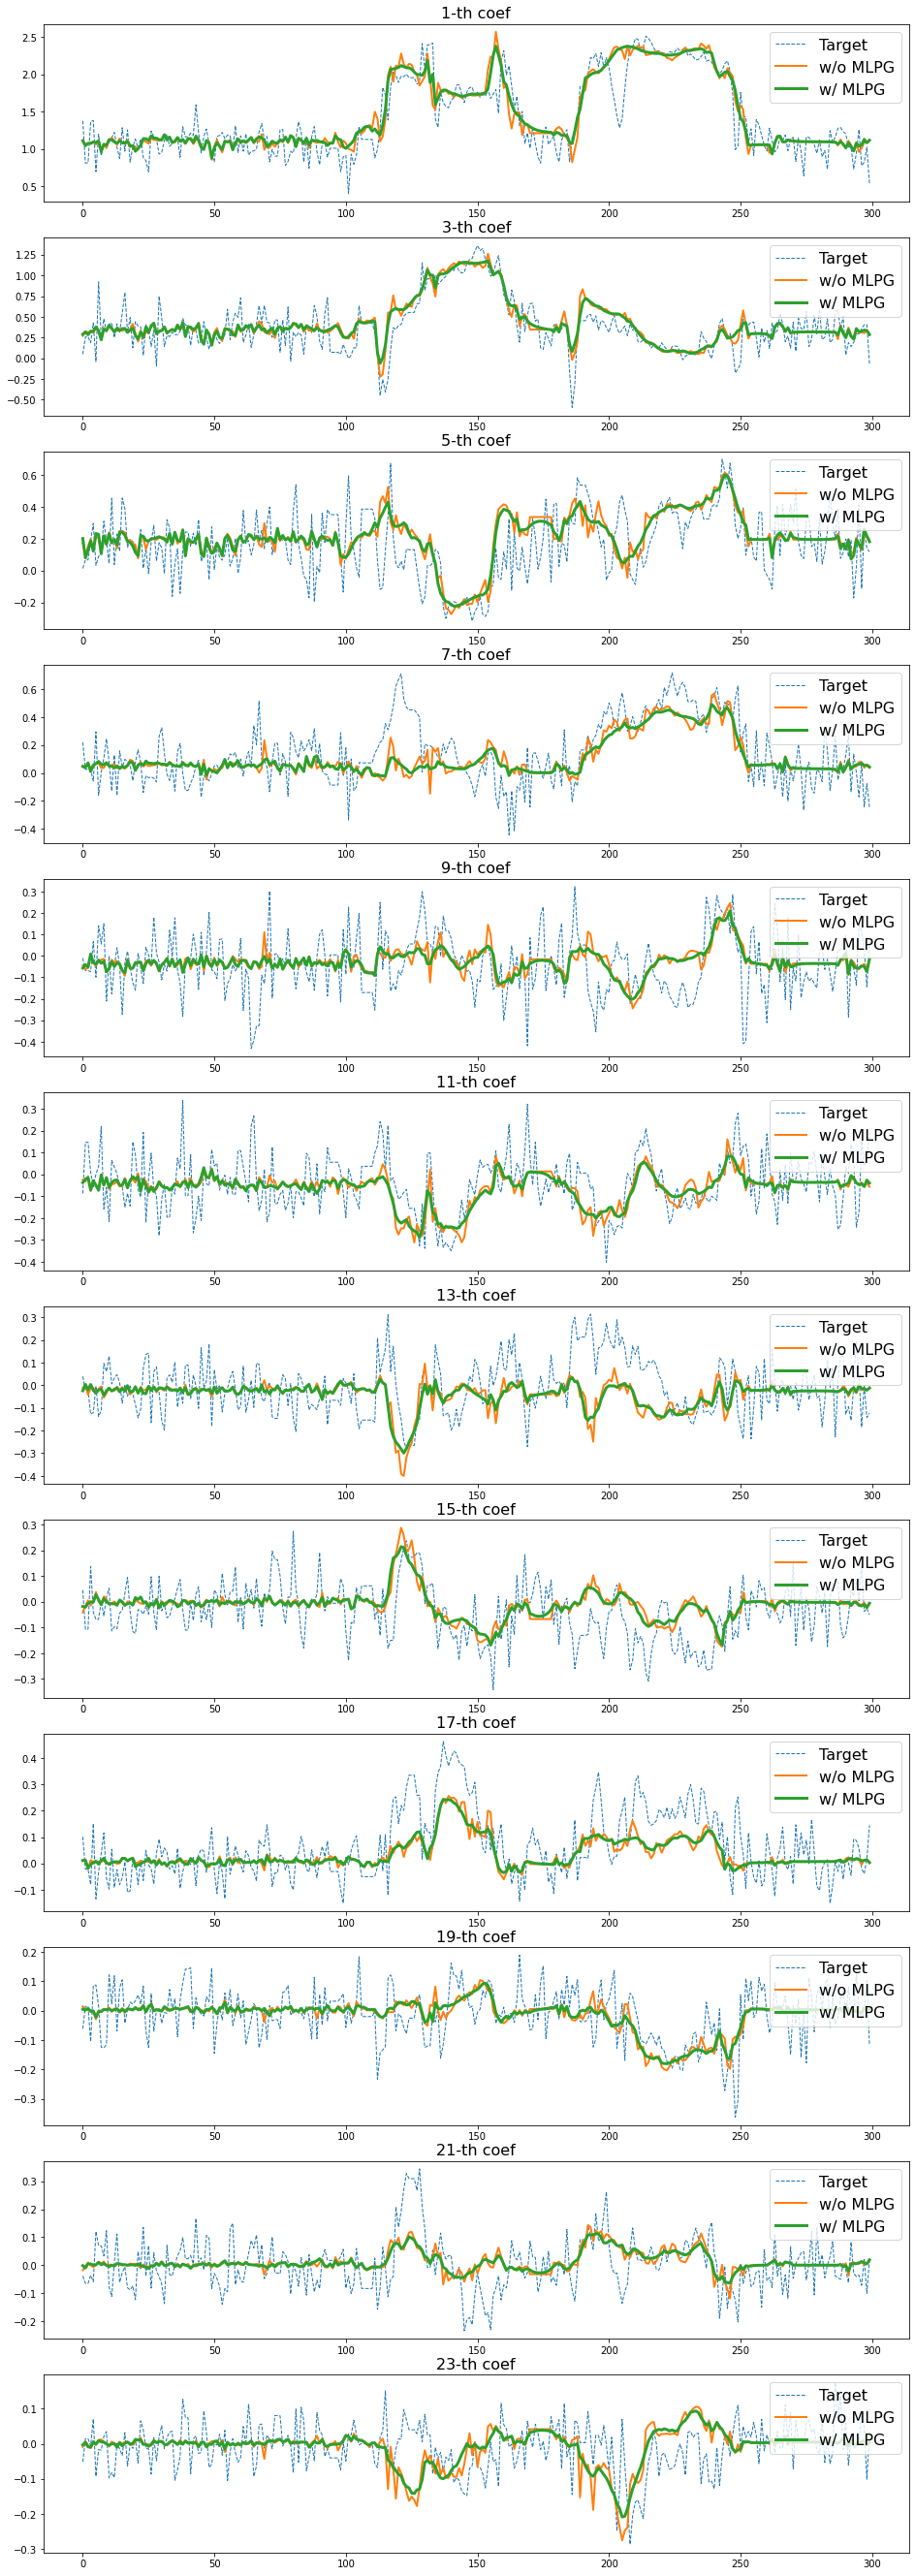

In [86]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

idx = 0
which_dims = np.arange(0, static_dim, step=2)
vis_difference(X_aligned[idx], Y_aligned[idx], T_max=300, which_dims=which_dims)